# Reddit Project Starter Script

### Putting data into your own bucket

In the following cell, you will copy your assigned subreddit from the central teaching bucket to your own persaonl bucket. This cell MUST only be executed once per account!!

### Reading your entire dataset

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql.functions import col, lit
from pyspark.sql import SparkSession

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, StringType, DateType
from pyspark.sql import Window
from pyspark.sql import functions as F

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer, StandardScaler, MinMaxScaler, IndexToString
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.sql.types import *

import seaborn as sns

In [4]:
spark = SparkSession.builder.appName("reddit").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/04 15:40:46 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
22/05/04 15:40:54 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM has registered!


Make sure your SparkSession is active:

In [5]:
spark

In [7]:
#df = spark.read.parquet('s3://mk2080-lab/reddit/ym_partition=201907')
df = spark.read.parquet('s3://mk2080-lab/reddit/')

### Reading one month worth of data

In [8]:
!aws s3 ls s3://mk2080-lab/reddit/

                           PRE ym_partition=201907/
                           PRE ym_partition=201908/
                           PRE ym_partition=201909/
                           PRE ym_partition=201910/
                           PRE ym_partition=201911/
                           PRE ym_partition=201912/
                           PRE ym_partition=202001/
                           PRE ym_partition=202002/
                           PRE ym_partition=202003/
                           PRE ym_partition=202004/
                           PRE ym_partition=202005/
                           PRE ym_partition=202006/
                           PRE ym_partition=202007/
                           PRE ym_partition=202008/
                           PRE ym_partition=202009/
                           PRE ym_partition=202010/
                           PRE ym_partition=202011/
                           PRE ym_partition=202012/
                           PRE ym_partition=202101/
            

In [52]:
df = spark.read.parquet('s3://mk2080-lab/reddit/')

### Clean data 

In [7]:
df.printSchema()

root
 |-- all_awardings: string (nullable = true)
 |-- associated_award: string (nullable = true)
 |-- author: string (nullable = true)
 |-- author_created_utc: double (nullable = true)
 |-- author_flair_background_color: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_richtext: string (nullable = true)
 |-- author_flair_template_id: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_flair_text_color: string (nullable = true)
 |-- author_flair_type: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- author_patreon_flair: boolean (nullable = true)
 |-- author_premium: boolean (nullable = true)
 |-- awarders: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- can_mod_post: boolean (nullable = true)
 |-- collapsed: boolean (nullable = true)
 |-- collapsed_because_crowd_control: string (nullable = true)
 |-- collapsed_reason: 

In [9]:
## change booleans to string for cleaning purposes
from pyspark.sql.types import StringType

df = df.withColumn("author_patreon_flair", col("author_patreon_flair").cast(StringType())) \
   .withColumn("author_premium",col("author_premium").cast(StringType())) \
   .withColumn("can_gild",col("can_gild").cast(StringType())) \
   .withColumn("can_mod_post",col("can_mod_post").cast(StringType())) \
   .withColumn("collapsed",col("collapsed").cast(StringType())) \
   .withColumn("is_submitter",col("is_submitter").cast(StringType())) \
   .withColumn("locked",col("locked").cast(StringType())) \
   .withColumn("quarantined",col("quarantined").cast(StringType())) \
   .withColumn("send_replies",col("send_replies").cast(StringType())) \
   .withColumn("stickied",col("stickied").cast(StringType())) \
   .withColumn("author_cakeday",col("author_cakeday").cast(StringType())) \
   .withColumn("no_follow",col("no_follow").cast(StringType())) \
   .withColumn("editable",col("editable").cast(StringType()))

In [10]:
## look at NA's
def count_missing(df, col):
    """
    Function that counts missing values (nan, null, empty) in a column of the dataset.
    """
    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()

In [11]:
# check for missing percentages by column
for column in df.columns:
    missing_count = count_missing(df, column)
    missing_percentage = missing_count/df.count()*100
    print(f"{column}: {missing_percentage}")

22/05/04 15:42:39 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


all_awardings: 0.0


associated_award: 0.6042199939858268


author: 0.0
author_created_utc: 30.902302981567427
author_flair_background_color: 100.0
author_flair_css_class: 98.65617789814553


author_flair_richtext: 9.224685841637593
author_flair_template_id: 100.0
author_flair_text: 100.0
author_flair_text_color: 89.43149205650795


author_flair_type: 9.224685841637593


author_fullname: 9.224685841637593


author_patreon_flair: 9.224685841637593


author_premium: 8.322117342966125


awarders: 2.0101435962858796


body: 0.0005268196508787246


can_gild: 0.0


can_mod_post: 0.0


collapsed: 0.0
collapsed_because_crowd_control: 100.0
collapsed_reason: 99.40525222333697
comment_type: 100.0
controversiality: 0.0


created_utc: 0.0


distinguished: 36.940414800934875
edited: 98.26019917575904
gilded: 0.0


gildings: 0.0


id: 0.0


is_submitter: 0.0


link_id: 0.0


locked: 0.0


no_follow: 0.0


parent_id: 0.0


permalink: 0.0


quarantined: 0.0
removal_reason: 99.99996839082095


retrieved_on: 14.136035791705625
score: 0.0


send_replies: 0.0


stickied: 0.0


subreddit_id: 0.0


subreddit_name_prefixed: 14.136035791705625


subreddit_type: 0.0
top_awarded_type: 100.0
total_awards_received: 0.0


treatment_tags: 0.05191280839758952
author_cakeday: 99.62537854626014


editable: 38.55207201329608


media_metadata: 96.85098821883751
ym_partition: 0.0


#### Remove entirely empty columns

In [12]:
## some columns are entirely empty, let's drop those columns

for column in df.columns:
    if (df.filter(F.isnan(F.col(column)) == True).count() == df.select(F.col(column)).count()):
        df = df.drop(column) 

for column in df.columns:
    if (df.filter(F.col(column).isNull()).count() == df.select(F.col(column)).count()):
        df = df.drop(column)

#### Remove entirely homoegenous columns

In [13]:
## drop columns where all values are the exact same
col_counts = df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).collect()[0].asDict()

## select the cols with count=1 in an array
cols_to_drop = [c for c in df.columns if col_counts[c] == 1]

## drop the selected colum
df = df.drop(*cols_to_drop)

# Exploratory Analysis

Explore, assess and visualize the data. Aggregate, count, and summarize. Create graphs, tables, etc, and explain your findings in writing. Clean data if necessary. Extract useful information from the text of the comments to create additional variables in your dataset.

Recommended exploratory graph types: number of posts over time, changes in number of users posting, score variation from particular users, popular posts impact using score or commments

### Shape of the data

In [21]:
## shape
def shape_of_df(df):
    print(
    "Rows:",
    df.count(),
    "/ Columns:",
    len(df.columns)
    )

In [22]:
shape_of_df(df)

Rows: 7629095 / Columns: 38


### Extracting data from the text 

In [23]:
## length of characters 
df = df.withColumn('length_of_text', F.length('body'))

In [24]:
## Figuring out emojis
line = '🧠'
line.encode('utf-8')

b'\xf0\x9f\xa7\xa0'

In [25]:
## all emojis when encoded use the 'xf0' so we can can use that to create an emoji dummy variable
df = df.withColumn('encoded', decode(col('body'),'UTF-8'))
df = df.withColumn('text_has_emoji',when(df.encoded.contains('\xf0'),1).otherwise(0))

In [26]:
## has cuss words?
en_cuss_words = ['shit', 'crap', 'fuck', 'bitch', 'damn', 'ass']
df = df.withColumn('text_has_cussword',when(df.body.isin(en_cuss_words),1).otherwise(0))

### Column descriptions

In [18]:
def descriptives(columns):
    for c in columns:
        df.describe(c).show()
        
print(descriptives(df.columns))

+-------+--------------------+
|summary|       all_awardings|
+-------+--------------------+
|  count|             9490914|
|   mean|                null|
| stddev|                null|
|    min|                  []|
|    max|[{'award_type': '...|
+-------+--------------------+



+-------+----------------+
|summary|associated_award|
+-------+----------------+
|  count|         9490914|
|   mean|             NaN|
| stddev|             NaN|
|    min|            None|
|    max|             nan|
+-------+----------------+



+-------+--------------------+
|summary|              author|
+-------+--------------------+
|  count|             9490914|
|   mean|            Infinity|
| stddev|                 NaN|
|    min|------------------GL|
|    max|             zzzzzxr|
+-------+--------------------+

+-------+-------------------+
|summary| author_created_utc|
+-------+-------------------+
|  count|            6558003|
|   mean|1.449443209390906E9|
| stddev|8.971531653110369E7|
|    min|        1.1225232E9|
|    max|      1.625073263E9|
+-------+-------------------+



+-------+----------------------+
|summary|author_flair_css_class|
+-------+----------------------+
|  count|                127541|
|   mean|                  null|
| stddev|                  null|
|    min|                     F|
|    max|                     g|
+-------+----------------------+



+-------+---------------------+
|summary|author_flair_richtext|
+-------+---------------------+
|  count|              9490914|
|   mean|                  NaN|
| stddev|                  NaN|
|    min|                   []|
|    max|                  nan|
+-------+---------------------+



+-------+---------------+
|summary|author_fullname|
+-------+---------------+
|  count|        8615407|
|   mean|           null|
| stddev|           null|
|    min|      t2_100047|
|    max|       t2_zzzzc|
+-------+---------------+



+-------+--------------+
|summary|author_premium|
+-------+--------------+
|  count|       8701069|
|   mean|          null|
| stddev|          null|
|    min|         false|
|    max|          true|
+-------+--------------+



+-------+--------+
|summary|awarders|
+-------+--------+
|  count| 9300133|
|   mean|    null|
| stddev|    null|
|    min|    <NA>|
|    max|      []|
+-------+--------+



+-------+--------------------+
|summary|                body|
+-------+--------------------+
|  count|             9490914|
|   mean|                 NaN|
| stddev|                 NaN|
|    min|                    |
|    max|🩰"What does this...|
+-------+--------------------+



+-------+--------+
|summary|can_gild|
+-------+--------+
|  count| 9490914|
|   mean|    null|
| stddev|    null|
|    min|   false|
|    max|    true|
+-------+--------+



+-------+---------+
|summary|collapsed|
+-------+---------+
|  count|  9490914|
|   mean|     null|
| stddev|     null|
|    min|    false|
|    max|     true|
+-------+---------+

+-------+--------------------+
|summary|    collapsed_reason|
+-------+--------------------+
|  count|               56447|
|   mean|                null|
| stddev|                null|
|    min|comment score bel...|
|    max|potentially toxic...|
+-------+--------------------+

+-------+--------------------+
|summary|    controversiality|
+-------+--------------------+
|  count|             9490914|
|   mean|0.012070281113072987|
| stddev| 0.10919977419091166|
|    min|                   0|
|    max|                   1|
+-------+--------------------+

+-------+-------------------+
|summary|        created_utc|
+-------+-------------------+
|  count|            9490914|
|   mean|1.588889503262894E9|
| stddev|1.783304960263034E7|
|    min|         1561939205|
|    max|         1625097599|
+-------+----------

+-------+-------------+
|summary|distinguished|
+-------+-------------+
|  count|      5984931|
|   mean|         null|
| stddev|         null|
|    min|         None|
|    max|    moderator|
+-------+-------------+



+-------+--------------------+
|summary|              edited|
+-------+--------------------+
|  count|              165123|
|   mean|1.5915742453599317E9|
| stddev| 1.837073084547863E7|
|    min|       1.561940229E9|
|    max|       1.628364365E9|
+-------+--------------------+

+-------+--------------------+
|summary|              gilded|
+-------+--------------------+
|  count|             9490914|
|   mean|2.942814569808556E-4|
| stddev|0.019088406724845963|
|    min|                   0|
|    max|                  12|
+-------+--------------------+



+-------+--------------------+
|summary|            gildings|
+-------+--------------------+
|  count|             9490914|
|   mean|                null|
| stddev|                null|
|    min|{'gid_1': 1, 'gid...|
|    max|                  {}|
+-------+--------------------+



+-------+-------+
|summary|     id|
+-------+-------+
|  count|9490914|
|   mean|   null|
| stddev|   null|
|    min|esfzqam|
|    max|h3mfw3n|
+-------+-------+



+-------+------------+
|summary|is_submitter|
+-------+------------+
|  count|     9490914|
|   mean|        null|
| stddev|        null|
|    min|       false|
|    max|        true|
+-------+------------+



+-------+---------+
|summary|  link_id|
+-------+---------+
|  count|  9490914|
|   mean|     null|
| stddev|     null|
|    min|t3_207ojx|
|    max|t3_ob9sbe|
+-------+---------+



+-------+-------+
|summary| locked|
+-------+-------+
|  count|9490914|
|   mean|   null|
| stddev|   null|
|    min|  false|
|    max|   true|
+-------+-------+



+-------+---------+
|summary|no_follow|
+-------+---------+
|  count|  9490914|
|   mean|     null|
| stddev|     null|
|    min|    false|
|    max|     true|
+-------+---------+



+-------+----------+
|summary| parent_id|
+-------+----------+
|  count|   9490914|
|   mean|      null|
| stddev|      null|
|    min|t1_edjfkkl|
|    max| t3_ob9sbe|
+-------+----------+



+-------+--------------------+
|summary|           permalink|
+-------+--------------------+
|  count|             9490914|
|   mean|                null|
| stddev|                null|
|    min|/r/Showerthoughts...|
|    max|/r/Showerthoughts...|
+-------+--------------------+

+-------+--------------------+
|summary|        retrieved_on|
+-------+--------------------+
|  count|             8149275|
|   mean|1.5929756961004722E9|
| stddev|1.5055690813106552E7|
|    min|          1571171859|
|    max|          1622532536|
+-------+--------------------+

+-------+------------------+
|summary|             score|
+-------+------------------+
|  count|           9490914|
|   mean|10.391566502446445|
| stddev|148.04589867698036|
|    min|             -1136|
|    max|             37208|
+-------+------------------+



+-------+------------+
|summary|send_replies|
+-------+------------+
|  count|     9490914|
|   mean|        null|
| stddev|        null|
|    min|       false|
|    max|        true|
+-------+------------+



+-------+--------+
|summary|stickied|
+-------+--------+
|  count| 9490914|
|   mean|    null|
| stddev|    null|
|    min|   false|
|    max|    true|
+-------+--------+

+-------+---------------------+
|summary|total_awards_received|
+-------+---------------------+
|  count|              9490914|
|   mean| 0.003098226366817...|
| stddev|  0.12842764686224709|
|    min|                    0|
|    max|                  126|
+-------+---------------------+



+-------+--------------+
|summary|treatment_tags|
+-------+--------------+
|  count|       9490914|
|   mean|           NaN|
| stddev|           NaN|
|    min|          <NA>|
|    max|           nan|
+-------+--------------+



+-------+--------------+
|summary|media_metadata|
+-------+--------------+
|  count|       9487557|
|   mean|           NaN|
| stddev|           NaN|
|    min|          <NA>|
|    max|           nan|
+-------+--------------+

+-------+------------------+
|summary|      ym_partition|
+-------+------------------+
|  count|           9490914|
|   mean|201989.76287900197|
| stddev| 67.52548185901614|
|    min|            201907|
|    max|            202106|
+-------+------------------+



+-------+------------------+
|summary|    length_of_text|
+-------+------------------+
|  count|           9490914|
|   mean|176.19741776187203|
| stddev| 257.6948700813019|
|    min|                 0|
|    max|             10000|
+-------+------------------+



+-------+--------------------+
|summary|             encoded|
+-------+--------------------+
|  count|             9490914|
|   mean|                 NaN|
| stddev|                 NaN|
|    min|                    |
|    max|🩰"What does this...|
+-------+--------------------+



+-------+--------------------+
|summary|      text_has_emoji|
+-------+--------------------+
|  count|             9490914|
|   mean|7.586202972653635E-6|
| stddev|0.002754295957496...|
|    min|                   0|
|    max|                   1|
+-------+--------------------+



+-------+--------------------+
|summary|   text_has_cussword|
+-------+--------------------+
|  count|             9490914|
|   mean|4.214557207029797E-5|
| stddev|0.006491825649344675|
|    min|                   0|
|    max|                   1|
+-------+--------------------+

None


## Remove Outliers 

In [27]:
def remove_outliers(column, df):
    mean = df.agg({column: 'mean'}).collect()[0][0]
    stddev = df.agg({column: 'stddev'}).collect()[0][0]

    cutoff = mean + (stddev*2.5)

    df = df.filter(df.length_of_text < cutoff)
    return df

In [28]:
df = remove_outliers('score', df)
df = remove_outliers('length_of_text', df)
#df = remove_outliers('text_has_cussword', df)
#df = remove_outliers('controversiality', df)

### Plot Distributions

In [31]:
pd_df = df.sample(0.25).toPandas()

In [29]:
def histogram(df, col, bins=5, xname=None, yname=None):
    
    '''
    This function makes a histogram from spark dataframe named 
    df for column name col. 
    '''
    
    # Calculating histogram in Spark 
    vals = df.select(col).rdd.flatMap(lambda x: x).histogram(bins)
    
    # Preprocessing histogram points and locations 
    width = vals[0][1] - vals[0][0]
    loc = [vals[0][0] + (i+1) * width for i in range(len(vals[1]))]
    
    # Making a bar plot 
    plt.bar(loc, vals[1], width=width,color="#4404f4")
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.show()

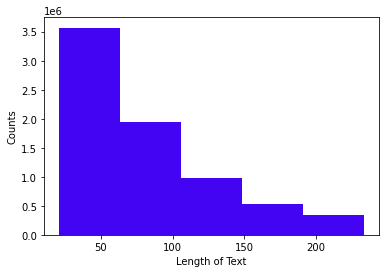

<Figure size 432x288 with 0 Axes>

In [30]:
## Length of text
histogram(df, 'length_of_text', xname = 'Length of Text', yname='Counts')
plt.savefig('score_dist')

#### text has emoji

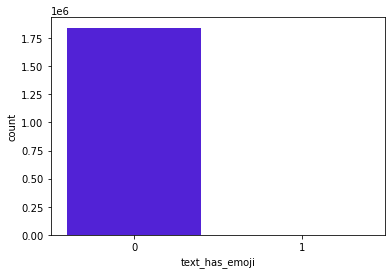

In [32]:
import seaborn as sns
p = sns.countplot(data=pd_df, x='text_has_emoji', color="#4404f4")
plt.savefig('has_emoji')

In [33]:
## filter 
df.filter(df.text_has_emoji ==1).count()

49

#### text has cussword

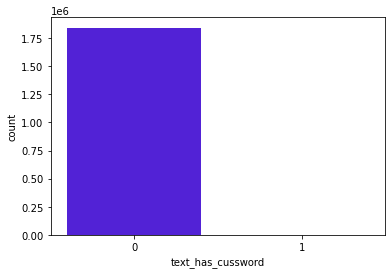

In [41]:
############## bar graph
p = sns.countplot(data=pd_df, x='text_has_cussword', color="#4404f4")
plt.savefig('has_cussword')

In [35]:
## filter 
df.filter(df.text_has_cussword == 1).count()

400

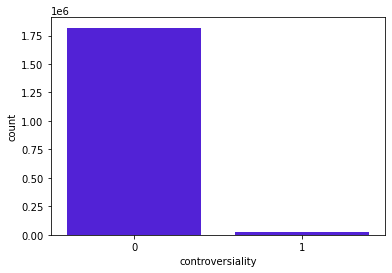

In [36]:
## Controversiality
p = sns.countplot(data=pd_df, x='controversiality', color="#4404f4")
plt.savefig('controversiality')

In [37]:
## filter 
df.filter(df.controversiality == 1).count()

93448

### Gilded

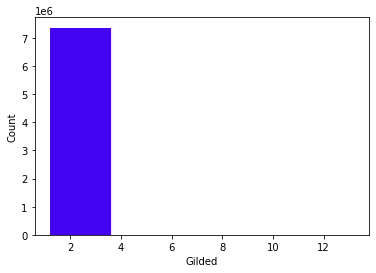

<Figure size 432x288 with 0 Axes>

In [38]:
histogram(df, 'gilded', xname = 'Gilded',yname='Count')
plt.savefig('gilded')

### Total Awards Received

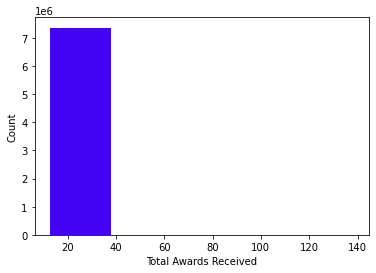

<Figure size 432x288 with 0 Axes>

In [39]:
########## manually change to limit max
histogram(df, 'total_awards_received',xname = 'Total Awards Received', yname='Count')
plt.savefig('total_awards')

## Score

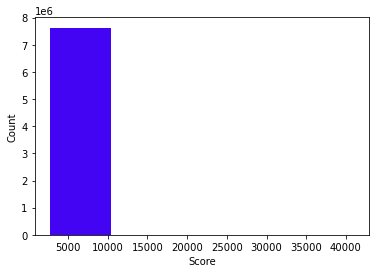

In [62]:
## Score
histogram(df, 'score', xname = 'Score', yname='Count')

In [77]:
df_score = df.filter(df.score < 500)
#vals = df.select('score').rdd.flatMap(lambda x: x).histogram(5)

In [85]:
vals

([-1136, -809, -482, -155, 172, 499], [2, 5, 162, 7563936, 39435])

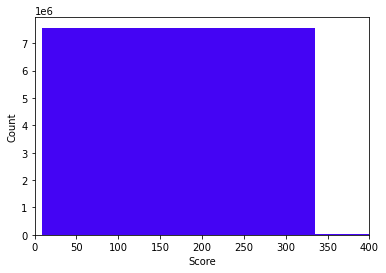

In [82]:
# Preprocessing histogram points and locations 
vals = df_score.select('score').rdd.flatMap(lambda x: x).histogram(5)

width = vals[0][1] - vals[0][0]
loc = [vals[0][0] + (i+1) * width for i in range(len(vals[1]))]

# Making a bar plot 
plt.bar(loc, vals[1], width=width, color="#4404f4")
plt.xlim((0, 400))
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

### Over time

In [42]:
def boxplot(df, col, group_by, samp_size=10000): 
    
    '''
    This function makes a box plot for a Spark dataframe df 
    grouping them by a column name called group_by and their
    aggrigate on another column called col. 
    '''
    
    # Selecting sample for the large dataset 
    # For samll data sampling is not done. For the large data 
    # sample size is the specified number. 
    
    #true_samp_size = min(samp_size/df.count(), 1.0)
    pd_df = df.sample(False, samp_size).toPandas()
    
    # Making plot 
    pd_df.boxplot(col, by=group_by, figsize=(8, 5))
    plt.ylabel(col)

    plt.title(None)
    plt.show()

In [43]:
df = df.withColumn("created_utc", col("created_utc").cast('TIMESTAMP'))

df = df.withColumn("day_of_year",dayofyear(df.created_utc)) \
    .withColumn("month_of_year",month(df.created_utc))

In [30]:
#true_samp_size = min(samp_size/df.count(), 1.0)
#pd_df = df.sample(10000)#.toPandas()


In [ ]:
## plot box plots by month of year to check for seasonality
pd_df = df.sample(0.25).toPandas()
pd_df.boxplot('score', by='month_of_year', figsize=(8, 5), color="#4404f4")
plt.ylabel(col)

plt.title(None)
plt.show()

# Model 
Build a supervised learning model (either regression or classification type) to build insights on the data. You must have evaluation metrics on the performance of your method - R2, accuracy, F1, etc. You are welcome to try different modeling techniques that you are comfortable with - linear/logit regression, random forest, gradient boosting, neural network, etc.

Recommended model types:
Predicting score of reddit posts based on the text, user, etc.
Predicting number of reddit posts over time



In [82]:
features = ['length_of_text', 'text_has_emoji', 'text_has_cussword', 'controversiality', 'gilded']

In [83]:
# Index and encode categorical feature 'last_state'
stringIndexerState = StringIndexer(inputCol="last_state", 
                                   outputCol="stateIndex")

encoder = OneHotEncoder(inputCol="stateIndex",
                        outputCol="stateVec")



# Merge multiple columns into a vector column
assemblers = VectorAssembler(inputCols=features, outputCol="rawFeatures", handleInvalid = "keep")

# Scale features
scalers = MinMaxScaler(inputCol="rawFeatures", outputCol='features')

## Linear Regression Classifier

In [84]:
#Input all the features in one vector column
assembler = VectorAssembler(inputCols=features, outputCol = 'Attributes')

output = assembler.transform(df)

#Input vs Output
finalized_data = output.select("Attributes","score")

finalized_data.show()

+---------------+-----+
|     Attributes|score|
+---------------+-----+
|(5,[0],[254.0])|    2|
|  (5,[0],[9.0])|    1|
|(5,[0],[131.0])|   18|
|  (5,[0],[9.0])|    3|
| (5,[0],[36.0])|    2|
| (5,[0],[16.0])|    2|
| (5,[0],[47.0])|   62|
| (5,[0],[68.0])|    1|
|(5,[0],[126.0])|   59|
| (5,[0],[40.0])|    2|
| (5,[0],[17.0])|    2|
| (5,[0],[27.0])|    3|
| (5,[0],[46.0])|    1|
| (5,[0],[88.0])|    2|
|  (5,[0],[9.0])|    3|
| (5,[0],[55.0])|    6|
| (5,[0],[17.0])|    9|
| (5,[0],[70.0])|    4|
|  (5,[0],[7.0])|    2|
| (5,[0],[46.0])|   10|
+---------------+-----+
only showing top 20 rows



In [85]:
#Split training and testing data
train_data,test_data = finalized_data.randomSplit([0.8,0.2])

regressor = LinearRegression(featuresCol = 'Attributes', labelCol = 'score')

#Learn to fit the model from training set
regressor = regressor.fit(train_data)

#To predict the prices on testing set
pred = regressor.evaluate(test_data)

#Predict the model
pred.predictions.show()

22/05/04 02:14:31 WARN Instrumentation: [edc09c81] regParam is zero, which might cause numerical instability and overfitting.


+-------------+-----+------------------+
|   Attributes|score|        prediction|
+-------------+-----+------------------+
|    (5,[],[])|    1|7.9136450244740795|
|(5,[0],[1.0])|    0| 7.962792932365193|
|(5,[0],[1.0])|    0| 7.962792932365193|
|(5,[0],[1.0])|    1| 7.962792932365193|
|(5,[0],[1.0])|    1| 7.962792932365193|
|(5,[0],[1.0])|    1| 7.962792932365193|
|(5,[0],[1.0])|    1| 7.962792932365193|
|(5,[0],[1.0])|    1| 7.962792932365193|
|(5,[0],[1.0])|    1| 7.962792932365193|
|(5,[0],[1.0])|    1| 7.962792932365193|
|(5,[0],[1.0])|    1| 7.962792932365193|
|(5,[0],[1.0])|    1| 7.962792932365193|
|(5,[0],[1.0])|    1| 7.962792932365193|
|(5,[0],[1.0])|    2| 7.962792932365193|
|(5,[0],[1.0])|    2| 7.962792932365193|
|(5,[0],[1.0])|    2| 7.962792932365193|
|(5,[0],[1.0])|    3| 7.962792932365193|
|(5,[0],[1.0])|    3| 7.962792932365193|
|(5,[0],[1.0])|    3| 7.962792932365193|
|(5,[0],[1.0])|    3| 7.962792932365193|
+-------------+-----+------------------+
only showing top

In [86]:
#coefficient of the regression model
coeff = regressor.coefficients

#X and Y intercept
intr = regressor.intercept

print ("The coefficient of the model is : %a" %coeff)
print ("The Intercept of the model is : %f" %intr)

The coefficient of the model is : DenseVector([0.0491, -8.708, -5.0413, -11.7212, 1617.1881])
The Intercept of the model is : 7.913645


## Logistic Regression Classifier

In [87]:
## turn into binary classification problem
df = df.withColumn('has_high_score', when(df.score > 100, 1).otherwise(0))

In [88]:
#Input all the features in one vector column
assembler = VectorAssembler(inputCols=features, outputCol = 'Attributes')

output = assembler.transform(df)

#Input vs Output
finalized_data = output.select("Attributes",'has_high_score')

finalized_data.show()

+---------------+--------------+
|     Attributes|has_high_score|
+---------------+--------------+
|(5,[0],[254.0])|             0|
|  (5,[0],[9.0])|             0|
|(5,[0],[131.0])|             0|
|  (5,[0],[9.0])|             0|
| (5,[0],[36.0])|             0|
| (5,[0],[16.0])|             0|
| (5,[0],[47.0])|             0|
| (5,[0],[68.0])|             0|
|(5,[0],[126.0])|             0|
| (5,[0],[40.0])|             0|
| (5,[0],[17.0])|             0|
| (5,[0],[27.0])|             0|
| (5,[0],[46.0])|             0|
| (5,[0],[88.0])|             0|
|  (5,[0],[9.0])|             0|
| (5,[0],[55.0])|             0|
| (5,[0],[17.0])|             0|
| (5,[0],[70.0])|             0|
|  (5,[0],[7.0])|             0|
| (5,[0],[46.0])|             0|
+---------------+--------------+
only showing top 20 rows



In [89]:
#Split training and testing data
train_data,test_data = finalized_data.randomSplit([0.8,0.2])

# Initialize Logistic Regression Classifier
lr = LogisticRegression(featuresCol='Attributes', labelCol='has_high_score')

#Learn to fit the model from training set
lr = lr.fit(train_data)

#To predict the prices on testing set
pred = lr.evaluate(test_data)

#Predict the model
pred.predictions.show()

+-------------+--------------+--------------------+--------------------+----------+
|   Attributes|has_high_score|       rawPrediction|         probability|prediction|
+-------------+--------------+--------------------+--------------------+----------+
|(5,[0],[1.0])|             0|[4.61429848200267...|[0.99018809506119...|       0.0|
|(5,[0],[1.0])|             0|[4.61429848200267...|[0.99018809506119...|       0.0|
|(5,[0],[1.0])|             0|[4.61429848200267...|[0.99018809506119...|       0.0|
|(5,[0],[1.0])|             0|[4.61429848200267...|[0.99018809506119...|       0.0|
|(5,[0],[1.0])|             0|[4.61429848200267...|[0.99018809506119...|       0.0|
|(5,[0],[1.0])|             0|[4.61429848200267...|[0.99018809506119...|       0.0|
|(5,[0],[1.0])|             0|[4.61429848200267...|[0.99018809506119...|       0.0|
|(5,[0],[1.0])|             0|[4.61429848200267...|[0.99018809506119...|       0.0|
|(5,[0],[1.0])|             0|[4.61429848200267...|[0.99018809506119...|    

In [51]:
#coefficient of the regression model
coeff = lr.coefficients

#X and Y intercept
intr = lr.intercept

print ("The coefficient of the model is : %a" %coeff)
print ("The Intercept of the model is : %f" %intr)

The coefficient of the model is : DenseVector([0.0041, -16.9144, 1.7021, -17.5305, 5.5463])
The Intercept of the model is : -4.714041


In [ ]:
#cvModel_lr = crossval_lr.fit(train)

In [ ]:
# Save model results
#cvModel_lr.save("s3://aws-emr-resources-489606719773-us-east-2/notebooks/e-4Z4HSYDPNRFEV3UFZ9WHLAGKM/models/cvModel_lr.mdl")

In [ ]:
# Upload model results
cvModel_lr_loaded = CrossValidatorModel.load("s3://aws-emr-resources-489606719773-us-east-2/notebooks/e-4Z4HSYDPNRFEV3UFZ9WHLAGKM/models/cvModel_lr.mdl/")

In [ ]:
bestModel_lr = cvModel_lr_loaded.bestModel

In [ ]:
bestModel_lr

In [ ]:
pred_train_best_lr = bestModel_lr.transform(train)
pred_test_best_lr = bestModel_lr.transform(test)

# Error Analysis
What is your error analysis, is there any pattern in your less-accurate prediction? Are you showing ROC curves, confusion matrices, residual plots, etc. as appropriate? Think about these questions.

## Linear Regression

In [43]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = eval.evaluate(pred.predictions)
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = eval.evaluate(pred.predictions, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = eval.evaluate(pred.predictions, {eval.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval.evaluate(pred.predictions, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 170.534


MSE: 29081.709


MAE: 16.849


r2: 0.148


## Logistic Regression

In [ ]:
colSelect = pred.predictions.select(
      [F.col('prediction').cast(DoubleType())
       ,F.col('has_high_score').cast(DoubleType()).alias('label')])

metrics = MulticlassMetrics(colSelect.rdd)
mMatrix = metrics.confusionMatrix().toArray().astype(int)

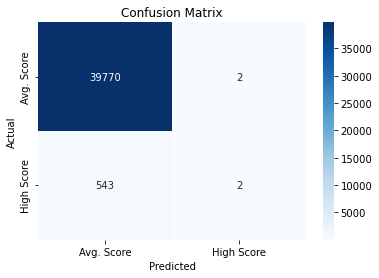

UsageError: Line magic function `%matplot` not found.


In [49]:
plt.clf()

ax= plt.subplot()
sns.heatmap(mMatrix, annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Avg. Score', 'High Score'])
ax.yaxis.set_ticklabels(['Avg. Score', 'High Score'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

%matplot plt

# Write-up